In [1]:
import os
import time
import math
import pandas as pd
import numpy as np
import torch
import torch.nn
import einops
import h5py
from tqdm import tqdm
import torchvision.datasets
import torchvision.transforms
from torch.utils.data import Dataset, DataLoader
import math
from sklearn.linear_model import RidgeClassifier, LinearRegression, LogisticRegression, Ridge, SGDClassifier
import sklearn.svm
from torchmetrics.classification import MulticlassHingeLoss
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

In [2]:
gpu = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = f'cuda:1'
torch.set_default_tensor_type('torch.cuda.DoubleTensor')

In [3]:
def random_fourie_features_complex(data, n_features=None, omega=None, random_seed=0):
    angle = data @ omega
    features_complex = np.exp(1j * angle)
    features = np.concatenate([np.real(features_complex), np.imag(features_complex)], axis=1)
    features = features / np.sqrt(features.shape[1])
    return features

def random_fourie_features_cos(data, omega, b, random_seed=0):
    angle = data @ omega + b
    features = np.sqrt(2) * np.cos(angle)
    features = features / np.sqrt(features.shape[1])
    return features

def random_relu_features(data, omega):
    angle = data @ omega.T
    features = np.copy(angle)
    features[features < 0] = 0
    return features

## Multiclass

In [4]:
mnist_train = torchvision.datasets.MNIST(
    'datasets/MNIST/',
    train=True,
    download=False,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        # torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

mnist_test = torchvision.datasets.MNIST(
    'datasets/MNIST/',
    train=False,
    download=False,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        # torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

data_train = mnist_train.data.detach().cpu().numpy()
targets_train = mnist_train.targets.detach().cpu().numpy()
data_test = mnist_test.data.detach().cpu().numpy()
data_test = einops.rearrange(data_test, 's w h -> s (w h)')
targets_test = mnist_test.targets.detach().cpu().numpy()
targets_test_onehot = np.zeros((targets_test.shape[0], 10))
targets_test_onehot[np.arange(targets_test.shape[0]), targets_test] = 1

n = 400
np.random.seed(0)
index = np.random.choice(data_train.shape[0], size=n, replace=False)
data_train_small = einops.rearrange(data_train, 's w h -> s (w h)')[index]
targets_train_small = targets_train[index]
targets_train_small_onehot = np.zeros((n, 10))
targets_train_small_onehot[np.arange(n), targets_train_small] = 1

ns_features = np.floor(np.logspace(1, np.log10(2500), 25)).astype(int) // 2 * 2

### ReLU

In [5]:
accuracy_train_list, accuracy_test_list = [], []
norm_list = []

for n_features in tqdm(ns_features):
    # n_features = 10000
    n_dim = data_train_small.shape[1]

    random_seed = 0
    np.random.seed(random_seed)
    omega = np.random.normal(0, 1, size=(n_features, n_dim))
    omega /= np.linalg.norm(omega, axis=0, keepdims=True)
    features_train_small = random_relu_features(data_train_small, omega)
    # features_train_small = data_train_small

    features_test = random_relu_features(data_test, omega)
    # features_test = data_test

    # linear_regression = Ridge(alpha=0, solver='saga')
    linear_regression = LinearRegression()
    linear_regression.fit(features_train_small, targets_train_small_onehot)
    norm = np.linalg.norm(linear_regression.coef_)
    norm_list.append(norm)
    
    targets_train_hat = linear_regression.predict(features_train_small)
    targets_train_hat = np.argmax(targets_train_hat, axis = 1)

    targets_test_hat = linear_regression.predict(features_test)
    targets_test_hat = np.argmax(targets_test_hat, axis = 1)

    accuracy_train = np.mean(targets_train_small == targets_train_hat)
    accuracy_train_list.append(accuracy_train)
    accuracy_test = np.mean(targets_test == targets_test_hat)
    accuracy_test_list.append(accuracy_test)
    # print(accuracy_train, accuracy_test)

accuracy_train_list = np.asarray(accuracy_train_list)
accuracy_test_list = np.asarray(accuracy_test_list)

lr_relu_risk01_train = 1 - accuracy_train_list
lr_relu_risk01_test = 1 - accuracy_test_list
lr_relu_norms = np.asarray(norm_list)

100%|██████████| 25/25 [00:04<00:00,  5.51it/s]


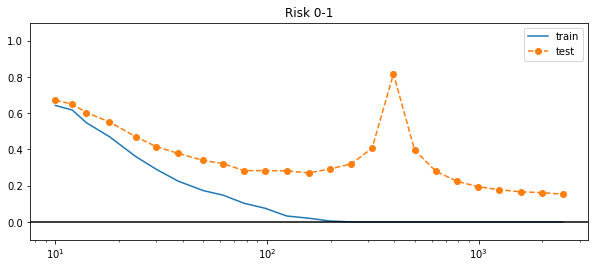

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.semilogx(ns_features, lr_relu_risk01_train, linestyle='-', label='train')
ax.semilogx(ns_features, lr_relu_risk01_test, linestyle='--', marker='o', label='test')
ax.axhline(y = 0, color = 'black', linestyle = '-')
ax.legend()
ax.set_title('Risk 0-1')
ax.set_ylim(-0.1, 1.1)
fig.savefig(f'figures/MNIST{n}_relu_LinearRegression')
plt.show()

### RFF

In [7]:
accuracy_train_list, accuracy_test_list = [], []
norm_list = []

for n_features in tqdm(ns_features):
    # n_features = 10000
    n_dim = data_train_small.shape[1]

    random_seed = 0
    np.random.seed(random_seed)
    scale = 0.001
    omega = np.random.normal(0, scale, size=(n_dim, n_features))
    # omega /= np.linalg.norm(omega, axis=0, keepdims=True)
    b = np.random.rand(1, n_features) * 2 * np.pi
    features_train_small = random_fourie_features_cos(data_train_small, omega, b)
    # features_train_small = data_train_small

    features_test = random_fourie_features_cos(data_test, omega, b)
    # features_test = data_test

    # linear_regression = Ridge(alpha=0, solver='saga')
    linear_regression = LinearRegression()
    linear_regression.fit(features_train_small, targets_train_small_onehot)
    norm = np.linalg.norm(linear_regression.coef_)
    norm_list.append(norm)
    
    targets_train_hat = linear_regression.predict(features_train_small)
    targets_train_hat = np.argmax(targets_train_hat, axis = 1)

    targets_test_hat = linear_regression.predict(features_test)
    targets_test_hat = np.argmax(targets_test_hat, axis = 1)

    accuracy_train = np.mean(targets_train_small == targets_train_hat)
    accuracy_train_list.append(accuracy_train)
    accuracy_test = np.mean(targets_test == targets_test_hat)
    accuracy_test_list.append(accuracy_test)

accuracy_train_list = np.asarray(accuracy_train_list)
accuracy_test_list = np.asarray(accuracy_test_list)

lr_rff_risk01_train = 1 - accuracy_train_list
lr_rff_risk01_test = 1 - accuracy_test_list
lr_rff_norms = np.asarray(norm_list)

100%|██████████| 25/25 [00:06<00:00,  4.09it/s]


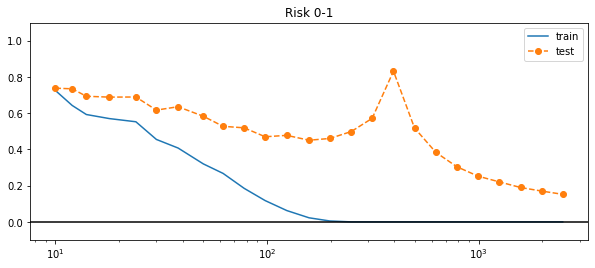

In [8]:
# ns_features = np.floor(np.logspace(1, np.log10(1000), 30)).astype(int) // 2 * 2
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.semilogx(ns_features, lr_rff_risk01_train, linestyle='-', label='train')
ax.semilogx(ns_features, lr_rff_risk01_test, linestyle='--', marker='o', label='test')
ax.axhline(y = 0, color = 'black', linestyle = '-')
ax.legend()
ax.set_title('Risk 0-1')
ax.set_ylim(-0.1, 1.1)
fig.savefig(f'figures/MNIST{n}_rff_LinearRegression')
plt.show()

## Logistic regression ReLU

In [9]:
accuracy_train_list, accuracy_test_list = [], []
norm_list = []

for n_features in tqdm(ns_features):
    # n_features = 10000
    n_dim = data_train_small.shape[1]

    random_seed = 0
    np.random.seed(random_seed)
    omega = np.random.normal(0, 1, size=(n_features, n_dim))
    omega /= np.linalg.norm(omega, axis=0, keepdims=True)
    features_train_small = random_relu_features(data_train_small, omega)
    # features_train_small = data_train_small

    features_test = random_relu_features(data_test, omega)
    # features_test = data_test

    # linear_regression = Ridge(alpha=0, solver='saga')
    logistic_regression = LogisticRegression(
        penalty='none', multi_class='multinomial', solver='saga', random_state=random_seed, max_iter=10000
    )
    logistic_regression.fit(features_train_small, targets_train_small)
    norm = np.linalg.norm(logistic_regression.coef_)
    norm_list.append(norm)
    
    targets_train_hat = logistic_regression.predict(features_train_small)
    # targets_train_hat = np.argmax(targets_train_hat, axis = 1)

    targets_test_hat = logistic_regression.predict(features_test)
    # targets_test_hat = np.argmax(targets_test_hat, axis = 1)

    accuracy_train = np.mean(targets_train_small == targets_train_hat)
    accuracy_train_list.append(accuracy_train)
    accuracy_test = np.mean(targets_test == targets_test_hat)
    accuracy_test_list.append(accuracy_test)
    # print(accuracy_train, accuracy_test)

accuracy_train_list = np.asarray(accuracy_train_list)
accuracy_test_list = np.asarray(accuracy_test_list)

lor_relu_risk01_train = 1 - accuracy_train_list
lor_relu_risk01_test = 1 - accuracy_test_list
lor_relu_norms = np.asarray(norm_list)

100%|██████████| 25/25 [04:42<00:00, 11.32s/it]


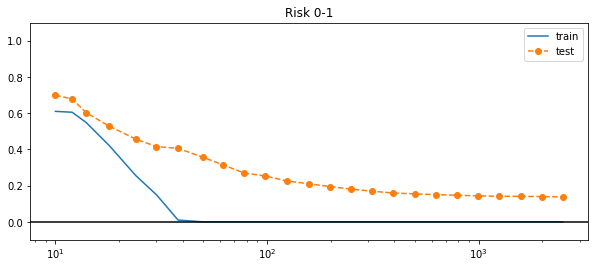

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.semilogx(ns_features, lor_relu_risk01_train, linestyle='-', label='train')
ax.semilogx(ns_features, lor_relu_risk01_test, linestyle='--', marker='o', label='test')
ax.axhline(y = 0, color = 'black', linestyle = '-')
ax.legend()
ax.set_title('Risk 0-1')
ax.set_ylim(-0.1, 1.1)
fig.savefig(f'figures/MNIST{n}_relu_LogisticRegression')
plt.show()

### SVM ReLU

In [39]:
accuracy_train_list, accuracy_test_list = [], []
norm_list = []

for n_features in tqdm(ns_features):
    # n_features = 10000
    n_dim = data_train_small.shape[1]

    random_seed = 0
    np.random.seed(random_seed)
    omega = np.random.normal(0, 1, size=(n_features, n_dim))
    omega /= np.linalg.norm(omega, axis=0, keepdims=True)
    features_train_small = random_relu_features(data_train_small, omega)
    # features_train_small = data_train_small

    features_test = random_relu_features(data_test, omega)
    # features_test = data_test

    # linear_regression = Ridge(alpha=0, solver='saga')
    svc = SGDClassifier(
        penalty='none', random_state=random_seed
    )
    svc.fit(features_train_small, targets_train_small)
    # norm = np.linalg.norm(logistic_regression.coef_)
    # norm_list.append(norm)
    
    targets_train_hat = svc.predict(features_train_small)
    # targets_train_hat = np.argmax(targets_train_hat, axis = 1)

    targets_test_hat = svc.predict(features_test)
    # targets_test_hat = np.argmax(targets_test_hat, axis = 1)

    accuracy_train = np.mean(targets_train_small == targets_train_hat)
    accuracy_train_list.append(accuracy_train)
    accuracy_test = np.mean(targets_test == targets_test_hat)
    accuracy_test_list.append(accuracy_test)
    # print(accuracy_train, accuracy_test)

accuracy_train_list = np.asarray(accuracy_train_list)
accuracy_test_list = np.asarray(accuracy_test_list)

svc_rbf_relu_risk01_train = 1 - accuracy_train_list
svc_rbf_relu_risk01_test = 1 - accuracy_test_list
svc_rbf_relu_norms = np.asarray(norm_list)

100%|██████████| 25/25 [00:03<00:00,  6.81it/s]


In [40]:
svc_linear_relu_risk01_train = 1 - accuracy_train_list
svc_linear_relu_risk01_test = 1 - accuracy_test_list
# svc_linear_relu_norms = np.asarray(norm_list)

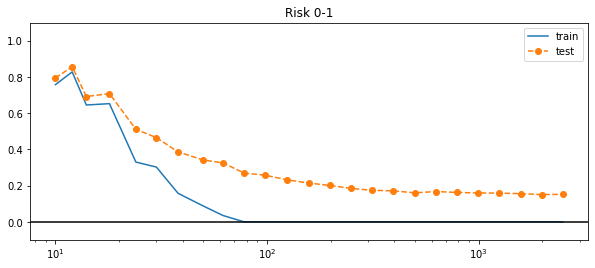

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.semilogx(ns_features, svc_linear_relu_risk01_train, linestyle='-', label='train')
ax.semilogx(ns_features, svc_linear_relu_risk01_test, linestyle='--', marker='o', label='test')
ax.axhline(y = 0, color = 'black', linestyle = '-')
ax.legend()
ax.set_title('Risk 0-1')
ax.set_ylim(-0.1, 1.1)
fig.savefig(f'figures/MNIST{n}_relu_SVC_Linear')
plt.show()

## SVM RFF

In [11]:
accuracy_train_list, accuracy_test_list = [], []
norm_list = []

for n_features in tqdm(ns_features):
    # n_features = 10000
    n_dim = data_train_small.shape[1]

    random_seed = 0
    np.random.seed(random_seed)

    scale = np.sqrt(1 / data_train_small.var() / n_features)
    omega = np.random.normal(0, scale, size=(n_dim, n_features))

    b = np.random.rand(1, n_features) * 2 * np.pi
    features_train_small = random_fourie_features_cos(data_train_small, omega, b)
    features_test = random_fourie_features_cos(data_test, omega, b)
    
    # linear_regression = Ridge(alpha=0, solver='saga')
    svc = SGDClassifier(
        penalty='none', random_state=random_seed
    )
    svc.fit(features_train_small, targets_train_small)
    # norm = np.linalg.norm(logistic_regression.coef_)
    # norm_list.append(norm)
    
    targets_train_hat = svc.predict(features_train_small)
    # targets_train_hat = np.argmax(targets_train_hat, axis = 1)

    targets_test_hat = svc.predict(features_test)
    # targets_test_hat = np.argmax(targets_test_hat, axis = 1)

    accuracy_train = np.mean(targets_train_small == targets_train_hat)
    accuracy_train_list.append(accuracy_train)
    accuracy_test = np.mean(targets_test == targets_test_hat)
    accuracy_test_list.append(accuracy_test)
    # print(accuracy_train, accuracy_test)

accuracy_train_list = np.asarray(accuracy_train_list)
accuracy_test_list = np.asarray(accuracy_test_list)

100%|██████████| 25/25 [00:05<00:00,  4.23it/s]


In [12]:
svc_linear_rff_risk01_train = 1 - accuracy_train_list
svc_linear_rff_risk01_test = 1 - accuracy_test_list

In [13]:
from sklearn.svm import SVC

In [14]:
csf = SVC(kernel='rbf')

In [16]:
csf.fit(data_train_small, targets_train_small)
targets_test_hat_ = csf.predict(data_test)

In [17]:
print(targets_test_hat_.shape, targets_test.shape)

(10000,) (10000,)


In [18]:
accuracy_rbf = np.mean(targets_test_hat_ == targets_test)

In [19]:
accuracy_rbf

0.8807

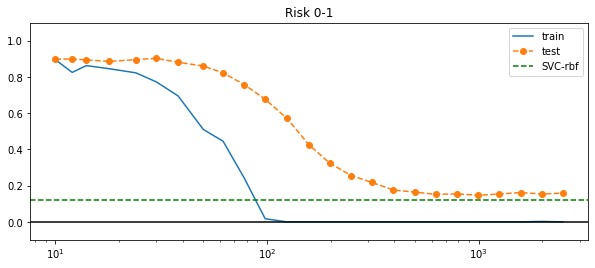

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.semilogx(ns_features, svc_linear_rff_risk01_train, linestyle='-', label='train')
ax.semilogx(ns_features, svc_linear_rff_risk01_test, linestyle='--', marker='o', label='test')
ax.axhline(y = 0, color = 'black', linestyle = '-')
ax.axhline(y = 1-accuracy_rbf, color = 'green', linestyle = '--', label='SVC-rbf')
ax.legend()
ax.set_title('Risk 0-1')
ax.set_ylim(-0.1, 1.1)
fig.savefig(f'figures/MNIST{n}_rff_SVC_Linear')
plt.show()

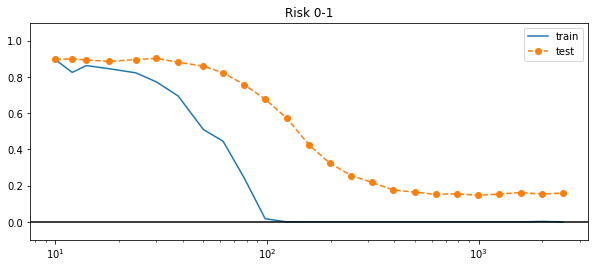

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.semilogx(ns_features, svc_linear_rff_risk01_train, linestyle='-', label='train')
ax.semilogx(ns_features, svc_linear_rff_risk01_test, linestyle='--', marker='o', label='test')
ax.axhline(y = 0, color = 'black', linestyle = '-')
ax.axhline(y = 1-accuracy_rbf, color = 'green', linestyle = '--', label='SVC-rbf')
ax.legend()
ax.set_title('Risk 0-1')
ax.set_ylim(-0.1, 1.1)
fig.savefig(f'figures/MNIST{n}_rff_SVC_Linear')
plt.show()

### SVM RFB

In [8]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import Pipeline

In [17]:
data_train_small.var()

6253.784652878356

In [35]:
accuracy_train_list, accuracy_test_list = [], []
norm_list = []
rbf = RBFSampler(n_components=1000, gamma=0.1, random_state=42)

for n_features in tqdm(ns_features):
    # n_features = 10000
    n_dim = data_train_small.shape[1]

    random_seed = 0
    np.random.seed(random_seed)
    # omega = np.random.normal(0, 1, size=(n_features, n_dim))
    # omega /= np.linalg.norm(omega, axis=0, keepdims=True)
    # features_train_small = random_relu_features(data_train_small, omega)
    # features_test = random_relu_features(data_test, omega)
    # features_test = data_test

    # linear_regression = Ridge(alpha=0, solver='saga')
    
    scale = 1 / (n_features * data_train_small.var())
    # scale = 1e-8
    rbf = RBFSampler(n_components=n_features, gamma=scale, random_state=random_seed)
    svc = SGDClassifier(
        penalty='none', random_state=random_seed
    )
    clf = Pipeline([
        ('rbf', rbf),
        ('svc', svc)
    ])
    
    clf.fit(data_train_small, targets_train_small)
    targets_train_hat = clf.predict(data_train_small)
    targets_test_hat = clf.predict(data_test)

    accuracy_train = np.mean(targets_train_small == targets_train_hat)
    accuracy_train_list.append(accuracy_train)
    accuracy_test = np.mean(targets_test == targets_test_hat)
    accuracy_test_list.append(accuracy_test)
    # print(accuracy_train, accuracy_test)

accuracy_train_list = np.asarray(accuracy_train_list)
accuracy_test_list = np.asarray(accuracy_test_list)

svc_rbf_relu_risk01_train = 1 - accuracy_train_list
svc_rbf_relu_risk01_test = 1 - accuracy_test_list
svc_rbf_relu_norms = np.asarray(norm_list)

100%|██████████| 25/25 [00:05<00:00,  4.32it/s]


In [36]:
svc_rbf_relu_risk01_train = 1 - accuracy_train_list
svc_rbf_relu_risk01_test = 1 - accuracy_test_list
svc_rbf_relu_norms = np.asarray(norm_list)

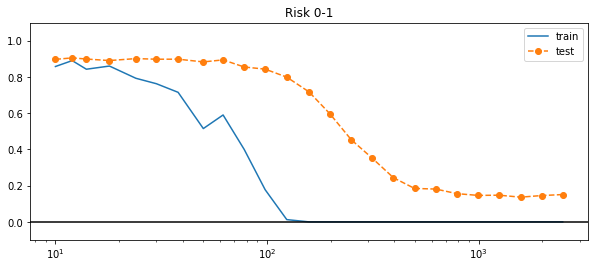

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.semilogx(ns_features, svc_rbf_relu_risk01_train, linestyle='-', label='train')
ax.semilogx(ns_features, svc_rbf_relu_risk01_test, linestyle='--', marker='o', label='test')
ax.axhline(y = 0, color = 'black', linestyle = '-')
ax.legend()
ax.set_title('Risk 0-1')
ax.set_ylim(-0.1, 1.1)
fig.savefig(f'figures/MNIST{n}_SVC_approxRBF')
plt.show()

### SVM HingeLoss

In [177]:
class LinearSVM(torch.nn.Module):
    def __init__(self, n_features, n_classes=10, random_seed=0):
        super(LinearSVM, self).__init__()
        self.n_features = n_features
        self.random_seed = random_seed
        torch.manual_seed(self.random_seed)
        self.linear = torch.nn.Linear(n_features, n_classes)

    def forward(self, x):
        x = self.linear(x)
        return x

In [178]:
from torchmetrics.classification import MulticlassHingeLoss

In [416]:
class TrainerSVM:
    def __init__(self, model, n_classes=10, lr=1e-3):
        self.model = model
        self.lr = lr
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr, momentum=0.01)
        # self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=0.99)
        self.criterion = MulticlassHingeLoss(num_classes=n_classes, multiclass_mode='crammer-singer')
        self.train_loss = []

    def fit(self, dataloader, nepoch=1, l=1):
        self.model.train()
        for epoch in tqdm(range(nepoch)):
            s = 0
            train_loss = 0
            for x, y in dataloader:
                self.optimizer.zero_grad()
                y_hat = self.model(x)
                loss = self.criterion(y_hat, y) + self.model.linear.weight
                loss.backward()
                self.optimizer.step()
                train_loss += loss.detach().cpu().numpy().item() * x.shape[0]
                s += x.shape[0]
            self.scheduler.step()
            train_loss = train_loss / s
            self.train_loss.append(train_loss)
        
    def predict(self, dataloader):
        self.model.eval()
        val_loss = 0
        val_y_hat = []
        val_y = []
        for x, y in dataloader:
            y_hat = self.model(x).squeeze(-1)
            loss = self.criterion(y_hat, y)
            val_loss += loss.detach().cpu().numpy().item() * x.shape[0]
            val_y_hat.append(y_hat.detach().cpu().numpy())
            val_y.append(y.detach().cpu().numpy())
        val_y_hat = np.concatenate(val_y_hat, axis=0)
        val_y_hat = np.argmax(val_y_hat, axis=1) 
        val_y = np.concatenate(val_y, axis=0)
            
        val_loss = val_loss / len(val_y)
        return val_loss, val_y, val_y_hat

In [417]:
class ImageDataset(Dataset):
    def __init__(self, data, targets, omega, random_seed=0):
        self.n_features = n_features
        # self.device = device
        self.labels = torch.tensor(targets, dtype=torch.long)#.to(self.device)

        features = random_relu_features(data, omega)
        self.samples = torch.tensor(features, dtype=torch.float64)#.to(self.device)
        
    def __len__(self):
        return self.samples.size(0)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]

In [418]:
n_features = 10000
n_dim = data_train_small.shape[1]
random_seed = 0
np.random.seed(random_seed)
omega = np.random.normal(0, 1, size=(n_features, n_dim))
omega /= np.linalg.norm(omega, axis=0, keepdims=True)
torch_dataset_train = ImageDataset(data_train_small, targets_train_small, omega)
torch_dataset_test = ImageDataset(data_test, targets_test, omega)

dataloader_train = DataLoader(torch_dataset_train, batch_size=n, shuffle=False, generator=torch.Generator(device='cuda'))
dataloader_test = DataLoader(torch_dataset_test, batch_size=n, shuffle=False, generator=torch.Generator(device='cuda'))

In [426]:
trainer.model.linear.weight

Parameter containing:
tensor([[ 0.0075, -0.7577,  0.2102,  ..., -0.1674,  0.0715, -0.1394],
        [-0.0069,  0.6110, -0.1963,  ...,  0.1003,  0.0390,  0.0422],
        [-0.0013, -0.0053, -0.1222,  ...,  0.0311,  0.0195,  0.0156],
        ...,
        [ 0.0077,  0.2473,  0.0244,  ...,  0.1840, -0.0110,  0.0246],
        [-0.0024,  0.0907,  0.0025,  ...,  0.0569,  0.0044,  0.0028],
        [-0.0012,  0.0030, -0.0071,  ...,  0.0200,  0.0022, -0.0063]],
       requires_grad=True)

In [419]:
model = LinearSVM(n_features)
trainer = TrainerSVM(model, lr=1e-1)

trainer.fit(dataloader_train, nepoch=10000)

100%|██████████| 10000/10000 [01:21<00:00, 123.19it/s]


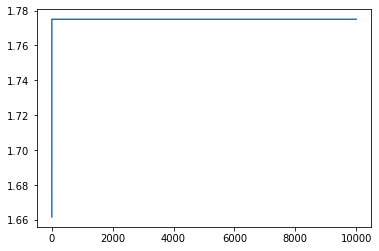

In [420]:
plt.plot(trainer.train_loss)

In [421]:
_, y_train, y_hat_train = trainer.predict(dataloader_train)
_, y_test, y_hat_test = trainer.predict(dataloader_test)

In [422]:
accuracy_train = np.mean(y_train == y_hat_train)
accuracy_test = np.mean(y_test == y_hat_test)
print(accuracy_train, accuracy_test)

0.1125 0.0962


### ROCKET

In [18]:
def load_dataset(path_dataset, dataset_name):

    training_data = np.loadtxt(f"{path_dataset}/{dataset_name}/{dataset_name}_TRAIN.txt")
    Y_training_, X_training = training_data[:, 0].astype(np.int32), training_data[:, 1:]

    test_data = np.loadtxt(f"{path_dataset}/{dataset_name}/{dataset_name}_TEST.txt")
    Y_test_, X_test = test_data[:, 0].astype(np.int32), test_data[:, 1:]

    classes_old = np.unique(Y_training_)
    n_classes = classes_old.shape[0]
    
    Y_training = np.zeros(Y_training_.shape[0]).astype(np.int32)
    Y_test = np.zeros(Y_test_.shape[0]).astype(np.int32)
    for i, c in enumerate(classes_old):
        Y_training[Y_training_ == c] = i
        Y_test[Y_test_ == c] = i

    return X_training, Y_training, X_test, Y_test, n_classes, classes_old

In [37]:
class RandomFeatures(torch.nn.Module):
    kernel_length = torch.tensor([7, 9, 11], dtype=torch.float)
    weight = None
    bias = None
    dilation = None
    padding = None
    
    def __init__(self, n_kernels, ts_length, random_seed=0):
        super(RandomFeatures, self).__init__()
        
        self.n_kernels = n_kernels
        self.ts_length = ts_length
        self.random_seed = random_seed * n_kernels
        self.create_kernels(self.random_seed)
        
    def create_kernels(self, random_seed=0):
        torch.manual_seed(random_seed)
        kernel_length_indices = torch.multinomial(self.kernel_length, self.n_kernels, replacement=True)
        kernel_lengths = self.kernel_length[kernel_length_indices].to(torch.long)
        weight_distributions_ = [torch.normal(mean=0, std=1, size=(kernel_length,), dtype=torch.double) for kernel_length in kernel_lengths]
        weight_distributions = [weight_distribution - weight_distribution.mean() for weight_distribution in weight_distributions_]
        self.weight = [weight_distribution.unsqueeze(0).unsqueeze(0) for weight_distribution in weight_distributions]
        
        self.bias = torch.rand(size=(self.n_kernels,), dtype=torch.double).reshape(-1,1) * 2 - 1
        A = math.log(self.ts_length-1) - torch.log(kernel_lengths-1)
        s = torch.rand(size=(self.n_kernels,)) * A
        self.dilation = torch.floor(2**s)
        self.padding = ((self.dilation * (kernel_lengths-1) / 2) * torch.randint(2, size=(self.n_kernels,)))
    
    
    def forward(self, x):
        batch_size = x.size(0)
        x = einops.rearrange(x, 'b t -> b 1 t')
        features = torch.empty(size=(batch_size, self.n_kernels, 2))
        
        for i in range(self.n_kernels):
            ts_convolved = torch.nn.functional.conv1d(
                x, weight=self.weight[i], bias=self.bias[i], 
                padding=int(self.padding[i].item()), dilation=int(self.dilation[i].item())
            )
            ts_convolved = ts_convolved.squeeze(1)

            ts_convolved_max = torch.max(ts_convolved, dim=1).values
            features[:,i,0] = ts_convolved_max

            ts_convolved_ppv = torch.mean((ts_convolved > 0).to(torch.float), dim=1)
            features[:,i,1] = ts_convolved_ppv
        
        features = einops.rearrange(features, 'b s f -> b (s f)')
        return features

In [58]:
class ROCKET():
    def __init__(self, n_features, ts_length, n_classes, random_seed=0):
        self.n_classes = n_classes
        self.random_seed = random_seed
        assert n_features % 2 == 0, 'n_features must be even'
        n_kernels = n_features // 2
        self.rf = RandomFeatures(n_kernels, ts_length, random_seed)
        self.lr = LinearRegression()

    def fit(self, X, y):
        X_ = torch.tensor(X, dtype=torch.double)
        features = self.rf(X_).detach().cpu().numpy()
        del X_
        y_onehot = np.zeros((y.shape[0], self.n_classes))
        y_onehot[np.arange(y.shape[0]), y] = 1
        self.lr.fit(features, y_onehot)

    def score(self, X, y):
        X_ = torch.tensor(X, dtype=torch.double)
        features = self.rf(X_).detach().cpu().numpy()
        del X_

        # y_onehot = np.zeros((y.shape[0], self.n_classes))
        # y_onehot[np.arange(y.shape[0]), y] = 1
        y_hat = self.lr.predict(features)
        y_hat = np.argmax(y_hat, axis = 1)
        accuracy = np.mean(y_hat == y)
        return accuracy

In [69]:
path_dataset = '../ROCKET/Univariate_arff/'
path_results = '../results/'
dataset85 = '../ROCKET/dataset85.txt'

with open(dataset85, 'r') as f:
    dataset_names = list(map(str.strip, f.readlines()))
# dataset_names = ['ElectricDevices', 'StarLightCurves', 'UWaveGestureLibraryAll']
    
n_datasets = len(dataset_names)
n_features = 10000
random_seed = 0
n_ts_max = 400

In [98]:
datasets, index, dataset_names_small = [], [], []
for i, dataset_name in enumerate(dataset_names):
    X_training, Y_training, X_test, Y_test, n_classes, classes_old = load_dataset(path_dataset, dataset_name)
    if (X_training.shape[0] <= n_ts_max):# and (X_test.shape[0] <= n_ts_max):
        datasets.append((X_training, Y_training, X_test, Y_test, n_classes))
        index.append(i)
        dataset_names_small.append(dataset_name)

In [120]:
filesave_train = 'results/accuracy_rocket_train.npy'
filesave_test = 'results/accuracy_rocket_test.npy'
epochs = 51
accuracy_train_arr = np.zeros((len(index), len(ns_features_rocket)))
accuracy_test_arr = np.zeros((len(index), len(ns_features_rocket)))

for i in tqdm(range(len(index))):
    n_features = 50000
    dataset = datasets[i]
    X_training, Y_training, X_test, Y_test, n_classes = dataset
    #ns_features_rocket = np.floor(np.logspace(np.log10(10), 1.5*np.log10(X_training.shape[0]), epochs)).astype(int) // 2 * 2
    ns_features_rocket = np.floor(np.logspace(np.log10(10), np.log10(X_training.shape[0]) + (np.log10(X_training.shape[0])-np.log10(10)), epochs)).astype(int) // 2 * 2
    ts_length = X_training.shape[1]
    for j, n_features in enumerate(ns_features_rocket):
        rocket = ROCKET(n_features, ts_length, n_classes)
        rocket.fit(X_training, Y_training)
        accuracy_train = rocket.score(X_training, Y_training)
        accuracy_test = rocket.score(X_test, Y_test)
        accuracy_train_arr[i,j] = accuracy_train
        accuracy_test_arr[i,j] = accuracy_test

np.save(filesave_train, accuracy_train_arr)
np.save(filesave_test, accuracy_test_arr)

100%|██████████| 61/61 [12:47<00:00, 12.59s/it]


In [121]:
accuracy_rocket_original = {}

with open('../ROCKET/accuracy.txt') as f:
    for line in f:
        line = line.split('&')
        line = [l.strip() for l in line]
        line = [l.strip('\\') for l in line]
        line = [l.strip() for l in line]
        accuracy_rocket_original[line[0]] = float(line[1])

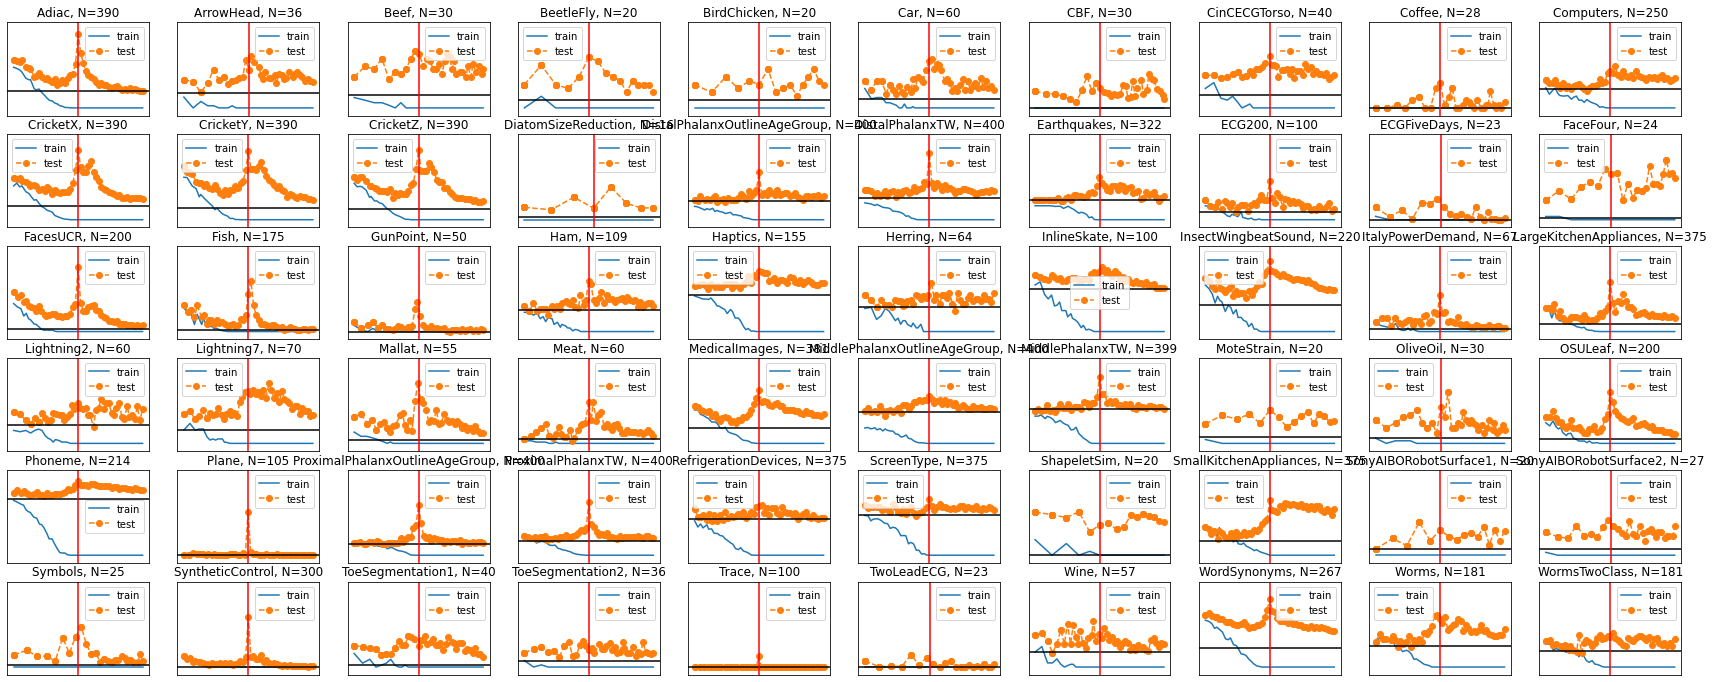

In [129]:
u, v = 6, 10
fig, ax = plt.subplots(u, v, figsize=(30, u*2))
for i in range(u):
    for j in range(v):
        dataset_name = dataset_names_small[i*v+j]
        X_training, _, _, _, _ = datasets[i*v+j]
        ns_features_rocket = np.floor(np.logspace(np.log10(10), np.log10(X_training.shape[0]) + (np.log10(X_training.shape[0])-np.log10(10)), epochs)).astype(int) // 2 * 2
        ax[i,j].semilogx(ns_features_rocket, 1 - accuracy_train_arr[i*v+j], linestyle='-', label='train')
        ax[i,j].semilogx(ns_features_rocket, 1 - accuracy_test_arr[i*v+j], linestyle='--', marker='o', label='test')
        ax[i,j].axhline(y = 1 - accuracy_rocket_original[dataset_name], color = 'black', linestyle = '-')
        ax[i,j].axvline(x = X_training.shape[0], ymin=0, ymax=1, color='red')
        ax[i,j].legend()
        ax[i,j].tick_params(
            axis='y',
            which='both', 
            left=False,      
            labelleft=False)
        ax[i,j].tick_params(
            axis='x',
            which='both', 
            bottom=False,      
            labelbottom=False)
        ax[i,j].set_title(f'{dataset_name}, N={X_training.shape[0]}')
        ax[i,j].set_ylim(-0.1, 1.1)
fig.savefig(f'figures/ROCKET')
plt.show()